In [2]:
import numpy as np
import matplotlib.pyplot as plt

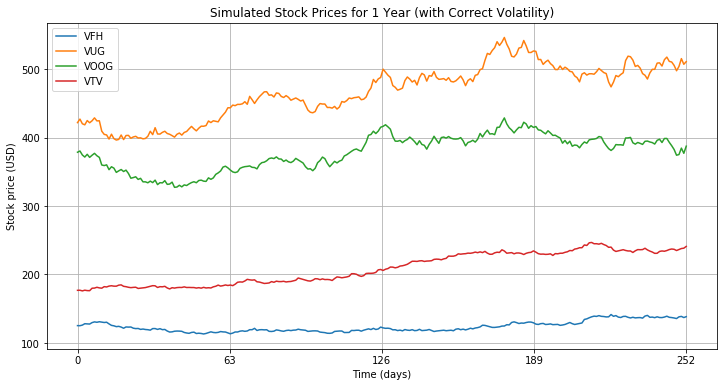

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
T = 1  # 预测时间（年）
dt = 1 / 252  # 时间步长（假设252个交易日）
N = int(T / dt)  # 时间步数
t = np.linspace(0, T, N)  # 时间轴

# 股票参数
mu = np.array([0.1272, 0.1615, 0.1565, 0.1093])  # 年化平均收益率
sigma = np.array([0.16, 0.18, 0.18, 0.11])  # 年化波动率
labels = ['VFH', 'VUG', 'VOOG', 'VTV']

# 相关性矩阵和Cholesky分解
R = np.array([
    [1, 0.07, 0.12, 0.24],
    [0.07, 1, 0.71, 0.05],
    [0.12, 0.71, 1, 0.23],
    [0.24, 0.05, 0.23, 1]
])
L = np.linalg.cholesky(R)

# 初始价格
S0 = np.array([125.33, 421.85, 378.59, 176.88])  # 四只股票的初始价格

# 生成独立的布朗运动增量（使用正态分布）
np.random.seed(42)  # 固定随机种子以便复现结果
independent_increments = np.random.normal(0, np.sqrt(dt), size=(4, N))

# 生成相关的布朗运动增量
correlated_increments = np.dot(L, independent_increments)

# 几何布朗运动模拟
S = np.zeros((4, N))
S[:, 0] = S0  # 初始价格

for i in range(1, N):
    drift = (mu - 0.5 * sigma**2) * dt  # 漂移项
    diffusion = sigma * correlated_increments[:, i]  # 扩散项（直接用增量）
    S[:, i] = S[:, i-1] * np.exp(drift + diffusion)

# 可视化
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.plot(t, S[i], label=labels[i])
plt.xticks(np.linspace(0, 1, 5), np.linspace(0, 252, 5, dtype=int))  # 显示交易日
plt.xlabel('Time (days)')
plt.ylabel('Stock price (USD)')
plt.legend()
plt.title('Simulated Stock Prices for 1 Year (with Correct Volatility)')
plt.grid(True)
plt.show()

In [5]:
price= np.vstack(S)
last_price=price[:, -1]

In [6]:
from scipy.optimize import minimize

# 假设做空利率（假设为 5%）
interest_rate=0.05  
initial_capital=10000
# 定义目标函数
def objective_function(w):
    w1, w2, w3, w4 = w
    # 投资组合的最终价值
    portfolio_value = w1 * last_price[0] + w2 * last_price[1] + w3 * last_price[2] + w4 * last_price[3]
    
    # 计算做空成本
    short_cost = 0
    for i, weight in enumerate(w):
        if weight<0:  
            short_cost+=abs(weight)*initial_capital/S0[i]*S0[i]*interest_rate
    
    # 目标函数：最大化投资组合的最终价值减去做空成本
    return -(portfolio_value - short_cost)  # 负号因为 minimize 是最小化

# 初始猜测
initial_guess = [0.25, 0.25, 0.25, 0.25]

# 约束条件：w1 + w2 + w3 + w4 = 1
constraints = ({'type': 'eq', 'fun': lambda w: w[0] + w[1] + w[2] + w[3] - 1})

# 变量范围
bounds = [(-1,1),(-1,1),(-1,1),(-1,1)]

# 优化求解
result = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints)

# 输出结果
if result.success:
    optimal_solution = result.x
    max_value = -result.fun 
    print("最优权重:", optimal_solution)
    print("最大收益:", max_value)
else:
    print("优化失败:", result.message)

最优权重: [ -1.92021873e-07   1.00000000e+00   4.57487321e-08   1.46273093e-07]
最大收益: 510.937920712838


In [9]:
# 最小化风险（标准差）
def min_risk_objective(weights):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(np.cov(S), weights)))
    return portfolio_std

# 优化
result = minimize(min_risk_objective, initial_guess, bounds=bounds, constraints=constraints)
optimal_weights_min_risk = result.x
max_value = np.dot(optimal_weights_min_risk,last_price)
allocation_min_risk = initial_capital * optimal_weights_min_risk

print("最小风险比重:", optimal_weights_min_risk)
print("按最小风险比重所分配金额:", allocation_min_risk)
print("最大收益:", max_value)

最小风险比重: [ 1.         -0.14935099  0.22297609 -0.0736251 ]
按最小风险比重所分配金额: [ 10000.          -1493.50993533   2229.76089802   -736.25096268]
最大收益: 130.757712999


In [5]:
# 最大化夏普比率
def max_sharpe_objective(weights):
    portfolio_return = np.dot(weights, last_price)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(np.cov(S), weights))) #假设无风险利率为0
    sharpe_ratio = portfolio_return / portfolio_std
    return -sharpe_ratio  

# 优化
result = minimize(max_sharpe_objective, initial_guess, bounds=bounds, constraints=constraints)
optimal_weights_max_sharpe = result.x
sharpe= -result.fun
max_value = np.dot(optimal_weights_max_sharpe,last_price)
print("最大夏普比率比重:", optimal_weights_max_sharpe)
print("夏普比率:", sharpe)
print("最大收益:", max_value)

最大夏普比率比重: [ 1.          0.02480443  0.34905303 -0.37385746]
夏普比率: 23.027533384961295
最大收益: 196.221372207


In [24]:
# 假设无风险利率2%
risk_free_rate = 0.02  

def max_sharpe_objective(weights):
    portfolio_return = np.dot(weights, last_price)
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(np.cov(S), weights))) #假设无风险利率为0
    sharpe_ratio = (portfolio_return-risk_free_rate) / portfolio_std
    return -sharpe_ratio  

# 优化
result = minimize(max_sharpe_objective, initial_guess, bounds=bounds, constraints=constraints)
optimal_weights_max_sharpe = result.x
sharpe= -result.fun
max_value = np.dot(optimal_weights_max_sharpe,last_price)
print("最大夏普比率比重:", optimal_weights_max_sharpe)
print("夏普比率:", sharpe)
print("最大收益:", max_value)

最大夏普比率比重: [ 0.63088818 -0.59957437  0.29650499  0.67218119]
夏普比率: 98.93735406942963
最大收益: 56.7010132338
